# CAP5415 Assignment 4

In [25]:
import pickle
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

# PyTorch imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

from PIL import Image as pil

In [26]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [27]:
cifar_dict = unpickle('../data/batches.meta')

Labels for the dataset

In [28]:
label_names = cifar_dict['label_names']
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Training images and labels

In [29]:
train_dict = unpickle('../data/data_batch_1')

In [30]:
train_labels = np.array(train_dict['labels'])
train_labels.shape

(10000,)

In [31]:
train_images = train_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32") / 255
train_images.shape

(10000, 32, 32, 3)

Visualizing a few images

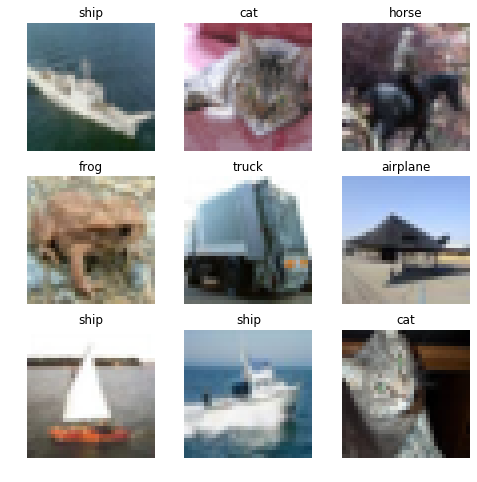

In [32]:
fig, axes1 = plt.subplots(3,3,figsize=(8,8))
for j in range(3):
    for k in range(3):
        i = np.random.choice(range(len(train_images)))
        axes1[j][k].set_title(label_names[train_labels[i]])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(train_images[i:i+1][0])

The below function will be used for calculating class covariance matrices for our LDF's

In [33]:
def covariance_matrix(image, mean):
    'Calculates covariance matrix for a given image'

    X = np.array(image, dtype=np.float64).reshape(3072, -1)

    X = X - mean
    
    N = X.shape[0]
    
    cov = (X @ X.T) / N
    
    return cov

## Fisher Linear Discriminant Function

**We will represent 3 channel 32x32 images as 3072 x 1 vectors**

Placing each class of image into its own bucket

In [34]:
images_dict = {i: [] for i in range(10)}

for i, image in enumerate(train_images):
    label = train_labels[i]
    images_dict[label].append(image)

images_dict = {i: np.array(images_dict[i]) for i in range(10)}   

Computing 3072x1 class mean vectors

In [35]:
# Average across every vector for each class, creating a 3072x1 mean vector for each digit

mean_dict = {i: np.mean(images_dict[i], axis = 0).reshape(-1,1) for i in range(10)}

In [36]:
mean_dict[0].shape

(3072, 1)

Computing 3072x3072 class covariance matrices

In [37]:
# Calculating the 3072x3072 covariance matrix for each of the classes

covariances = {i: covariance_matrix(images_dict[i], mean_dict[i]) for i in range(10)}

In [38]:
covariances[0].shape

(3072, 3072)

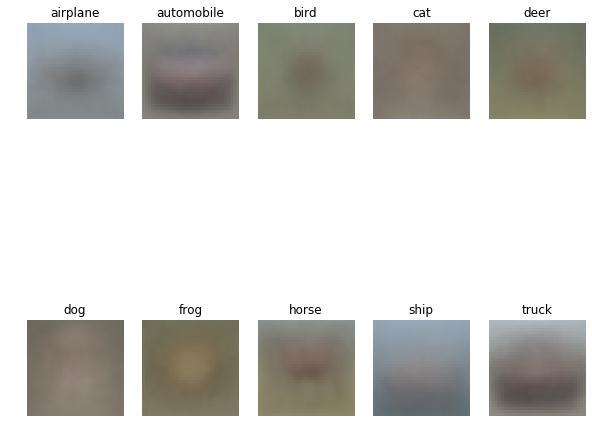

In [39]:
# Plotting means of each class
fig, axes1 = plt.subplots(2, 5,figsize=(10,10))
    
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(label_names[i])
    plt.axis('off')
    plt.imshow(mean_dict[i].reshape(32,32,3))

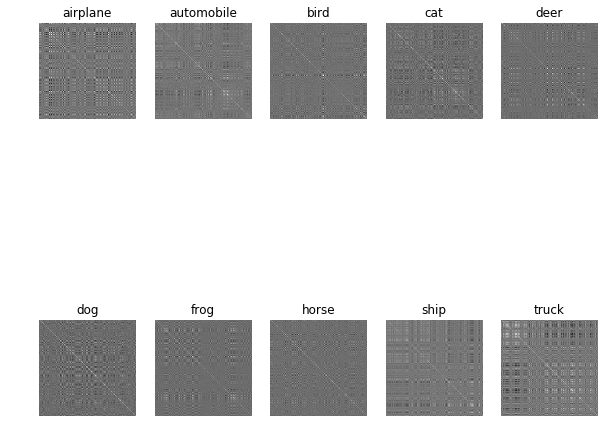

In [40]:
# Plotting covariance matrix of each class
fig, axes1 = plt.subplots(2, 5,figsize=(10,10))
    
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(label_names[i])
    plt.axis('off')
    plt.imshow(covariances[i], cmap='gray')

We then compute the overall mean of the data

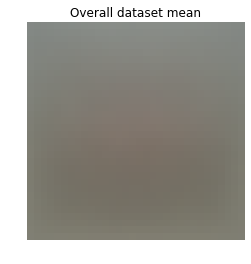

In [41]:
overall_mean = np.zeros((3072,1))

for i in range(10):
    overall_mean += mean_dict[i]

overall_mean /= 10

plt.imshow(overall_mean.reshape(32,32,3))
plt.title('Overall dataset mean')
plt.axis('off')
plt.show()

Computing the sum of all 10 covariances matrices, **A**

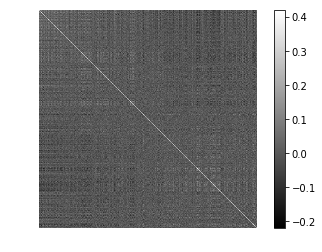

In [42]:
A = np.zeros((3072,3072))

for i in range(10):
    A += covariances[i]

plt.imshow(A, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

Computing the between class scatter matrix, **B**

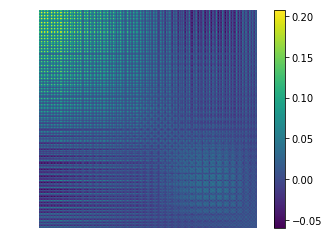

In [43]:
B = np.zeros((3072,3072))

for i in range(10):
    B += (mean_dict[i] - overall_mean) @ (mean_dict[i] - overall_mean).T
    
plt.imshow(B)
plt.axis('off')
plt.colorbar()
plt.show()

Compute A<sup>-1</sup>B and obtain its eigenvectors and eigenvalues

In [44]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(A) @ B)
eig_vals = eig_vals.real
eig_vecs= eig_vecs.real

The rank of B was 9, so there should only be 9 non-zero eigenvalues.

In [45]:
# We'll round off the eigenvalues a bit so we can find these easily

eig_vals = np.where(np.abs(eig_vals) > 0.0000001, eig_vals, 0)

Now we can find the non-zero eigenvalues and their corresponding eigenvectors

In [46]:
# Getting the index of each non-zero eigenvalue

nonzero_idxs = np.nonzero(eig_vals)[0]
len(nonzero_idxs)

9

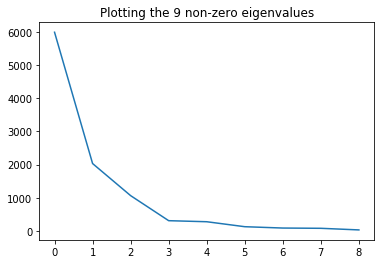

In [47]:
# Retreiving non-zero eigenvalues using the above indices
nonzero_eigs = eig_vals[nonzero_idxs]

plt.plot(nonzero_eigs)
plt.title('Plotting the 9 non-zero eigenvalues')
plt.show()

In [48]:
# Retrieving the 9 corresponding eigenvectors, creating the matrix H

H = eig_vecs[:, nonzero_idxs]
H.shape

(3072, 9)

These 3072x1 eigenvectors can be reshaped back into 32x32x3 images and visualized

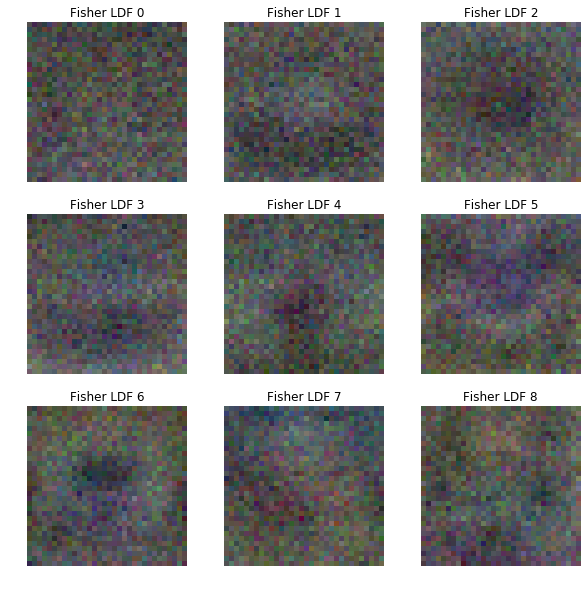

In [49]:
# Plotting each of our 9 filters
fig, axes1 = plt.subplots(3, 3,figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title('Fisher LDF {}'.format(i))
    plt.axis('off')
    
    # I adjust the brightness and contrast here so the LDF's are more visible
    plt.imshow(((H +  np.abs(H.min())) * 4)[:, i].reshape(32,32,3))

## Testing Fisher LDF's on the test set

Testing images and labels

In [50]:
test_dict = unpickle('../data/test_batch')

In [51]:
test_labels = np.array(test_dict['labels'])[:1000]
test_labels.shape

(1000,)

In [52]:
test_images = test_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32")[:1000] / 255

In [53]:
num_test_images = len(test_images)
test_images.shape

(1000, 32, 32, 3)

Now that we've computed our Fisher LDF's, the first step to predicting on the test set is to transorm the test images into the Fisher LDF space

We have 1000, 3072x1 test vectors

In [54]:
test_vectors = test_images.reshape(-1, 32 * 32 * 3).T
test_vectors.shape

(3072, 1000)

Since we have 9 LDF's, each fisher vector will be a 9x1 vector with the output of LDF1 as its first element, output of LDF2 as its second element, and so on.

In [55]:
fisher_vectors = []

for i in range(num_test_images):
    image_vec = test_vectors[:, i]
    fisher_vec = H.T @ image_vec
    fisher_vectors.append(fisher_vec)
    
fisher_vectors = np.array(fisher_vectors).T
fisher_vectors.shape

(9, 1000)

We also need to transform the class means and covariance matrices into the Fisher LDF space

In [56]:
# After transforming into fisher space, mean vectors are now 9x1

fisher_means = {i: H.T @ mean_dict[i] for i in range(10)}
print(fisher_means[0].shape)

(9, 1)


In [57]:
# Transforming into fisher space, covariance matrices are now 9x9

fisher_covariances = {i: H.T @ covariances[i] @ H for i in range(10)}
print(fisher_covariances[0].shape)

(9, 9)


We're now ready to test our Fisher LDF's on the test set. 

For each test image, we calculate its Mahalanobis distance to each of the class centers in the Fisher Feature space, and assign it the class which results in the smallest distance.

In [58]:
def test_ldf(fisher_vecs, means, covs):
    'Uses our Fisher LDFs to generate predictions on given a set of images in fisher space'
    preds = []

    # Loop through each precalculated fisher space vector 
    for x in range(num_test_images):

        f = fisher_vecs[:, x].reshape(-1,1)
        ds = []
        
        # Loop and test on each fisher LDA
        for i in range(10):
            
            # Calculating Mahalanobis distance
            f_m = f - means[i]
            inv_cov = np.linalg.inv(covs[i])
            d = f_m.T @ inv_cov @ f_m
            
            ds.append(d[0][0])

        ds = np.array(ds)
        
        # Assign class with smallest Mahalanobis distance
        pred = np.argmin(ds)
        
        # Add prediction to predictions array
        preds.append(pred)
        
    preds = np.array(preds)
    
    return preds

In [59]:
# Using our fisher LDF's to predict on the test set

test_preds = test_ldf(fisher_vectors, fisher_means, fisher_covariances)

We'll finally visualize our results with a confusion matrix and get accuracy/error metrics

In [60]:
test_cm = confusion_matrix(test_labels, test_preds)

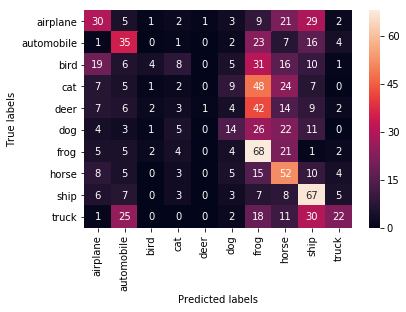

In [61]:
ax= plt.subplot()
sn.heatmap(test_cm, annot=True, ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

In [62]:
# Probability of correct recognition on test set
np.mean(test_labels == test_preds) 

0.295

In [63]:
# Probability of error on test set
np.mean(test_labels != test_preds)

0.705

## CNN

In [64]:
train_labels = np.array(train_dict['labels'])
train_images = train_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int")

test_labels = np.array(test_dict['labels'])[:1000]
test_images = test_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("int")[:1000]

In [65]:
input_size = (32,32)
batch_size = 32

PyTorch data transformations. Here is where we include zerocenter normalization

In [66]:
# To perform zerocenter normalization, we first must compute the channel-wise mean across the dataset

channel_means = [i for i in np.mean(train_images, axis = (0,1,2)) / 255]
channel_means

[0.49345784428615197, 0.4833751616115196, 0.44717916398590685]

PyTorch's Normalize transformation takes in an mean and standard deviation and for each pixel, subracts the mean and divides by the standard deviation. This normalizes each image to have a mean of 0 and standard deviation of 1. By providing this function a standard deviation of 1 for each channel, we are effectively computing only a zero-center normalization of the mean.

In [67]:
data_transforms = {
    'Train': transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(mean=channel_means,
                                 std=[1, 1, 1])
    ]),
    'Test': transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(mean=channel_means,
                                 std=[1, 1, 1])
    ])
}

Because I'm using PyTorch, I'll need to write a custom abstract dataset class to be used for loading images and their labels

In [68]:
class CifarDataset(Dataset):
    'Abstract PyTorch dataset class for the Cifar10 dataset'

    def __init__(self, images, labels, transform=None):

        # PyTorch expects pixel values 0-255 instead of 0-1
        self.images = images * 255
        self.labels = labels
        
        # Transformations to apply to each image (zero center normalization)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        # Indexes our numpy images and labels arrays, grabs a sample, and applies zero-centered normalization
        image = pil.fromarray(self.images[idx].astype('uint8'), 'RGB')
        label = torch.tensor(self.labels[idx])
        
        if self.transform:
            image = self.transform(image)

        return image, label

Instatiating a dataset class for training and testing

In [69]:
train_dataset = CifarDataset(train_images, train_labels, data_transforms['Train'])
test_dataset = CifarDataset(test_images, test_labels, data_transforms['Test'])

datasets = {'Train': train_dataset, 'Test': test_dataset}

We can now use these datasets to create PyTorch dataloaders, which will load batches of images for us on the fly

In [70]:
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True)
              for x in ['Train', 'Test']}

Here we're defining what component we'll use to train this model. We want to use the GPU if available, if not we use the CPU

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Creating the CNN architecture supplied in the assignment details 

In [72]:
class CNN(nn.Module):
  
    def __init__(self, batch_size):
        super(CNN, self).__init__()
        
        self.batch_size = batch_size
        
        # Conv, ReLU, MaxPool block, outputs 32 channels
        self.block1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        # Conv, ReLU, MaxPool block, outputs 32 channels
        self.block2 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), stride=1, padding=0),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Conv, ReLU, MaxPool block, outputs 64 channels
        self.block3 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=1, padding=0),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        # First fully connected block
        self.fc1 = nn.Sequential(
              # Fully connected layer
              nn.Linear(64,64),
              nn.ReLU()
        )
        
        # Final fully connected layer creates the prediction array
        self.fc2 = nn.Sequential(
              nn.Linear(64, 10),
              # PyTorch's CrossEntropyLoss includes a softmax before calculating the negative log likelihood loss
              # nn.Softmax()
        )
    
    # Feed the input through each of the layers we defined 
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Need to flatten activations before feeding into fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
      
        return x

Instantiating our CNN model. We're using Cross Entropy loss as our loss function, and the Adam gradient descent optimizer.

It should be noted that PyTorch's Cross Entropy loss function, by default, performs a softmax before computing the loss. Hence, my model does not include a final softmax activation, being that CrossEntropy does this for us.

In [73]:
model = CNN(batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 10
model.to(device)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
)

Training our CNN

In [74]:
def train(model, criterion, optimizer, num_epochs, dataloaders, device):
    'Trains our CNN model for a given number of epochs'
    start = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    print('| Epoch\t | Train Loss\t| Train Acc\t| Valid Loss\t| Valid Acc\t| Epoch Time |')
    print('-' * 86)
    
    # Iterate through epochs
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            running_loss = 0.0
            running_corrects = 0

            if phase == 'Train':
                model.train()
            else:
                model.eval()

            # Looping through batches
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                # ensures we're doing this calculation on our GPU if possible
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero parameter gradients
                optimizer.zero_grad()

                # Calculate gradients only if we're in the training phase
                with torch.set_grad_enabled(phase == 'Train'):

                    # This calls the forward() function on a batch of inputs
                    outputs = model(inputs)

                    # Calculate the loss of the batch
                    loss = criterion(outputs, labels)

                    # Gets the predictions of the inputs (highest value in the array)
                    _, preds = torch.max(outputs, 1)

                    # Adjust weights through backpropagation if we're in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # Document statistics for the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch statistics
            epoch_loss = running_loss / datasets[phase].__len__()
            epoch_acc = running_corrects.double() / datasets[phase].__len__()

            if phase == 'Train':
                train_loss = epoch_loss
                train_acc = epoch_acc

        epoch_time = time.time() - epoch_start

        # Print statistics after the validation phase
        print("| {}\t | {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.4f}\t| {:.0f}m {:.0f}s     |"
                      .format(epoch + 1, train_loss, train_acc, epoch_loss, epoch_acc, epoch_time // 60, epoch_time % 60))

        # Track the best accuracy thus far
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    total_time = time.time() - start
    
    print('-' * 86)
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))

    return model

In [51]:
model = train(model, criterion, optimizer, epochs, dataloaders, device)

| Epoch	 | Train Loss	| Train Acc	| Valid Loss	| Valid Acc	| Epoch Time |
--------------------------------------------------------------------------------------
| 1	 | 1.8752	| 0.2951	| 1.6558	| 0.4220	| 0m 4s     |
| 2	 | 1.5680	| 0.4165	| 1.4790	| 0.4680	| 0m 4s     |
| 3	 | 1.4303	| 0.4733	| 1.4532	| 0.4680	| 0m 4s     |
| 4	 | 1.3315	| 0.5133	| 1.3532	| 0.5160	| 0m 4s     |
| 5	 | 1.2488	| 0.5442	| 1.2822	| 0.5480	| 0m 4s     |
| 6	 | 1.1727	| 0.5747	| 1.2855	| 0.5470	| 0m 4s     |
| 7	 | 1.1087	| 0.5981	| 1.2920	| 0.5360	| 0m 4s     |
| 8	 | 1.0403	| 0.6264	| 1.2430	| 0.5610	| 0m 4s     |
| 9	 | 0.9828	| 0.6504	| 1.2911	| 0.5570	| 0m 4s     |
| 10	 | 0.9183	| 0.6704	| 1.2895	| 0.5860	| 0m 4s     |
--------------------------------------------------------------------------------------
Training complete in 0m 43s
Best validation accuracy: 0.5860


With our model trained, we can now generate predictions on the test set and see how we fared versus our Fisher LDFs

In [52]:
# Creating a dataloader to return a single image at a time from our test set

test_loader = DataLoader(datasets['Test'], batch_size=1, shuffle=False)

In [53]:
def test_cnn(model, images):
    'Uses our trained CNN to generate predictions on given a set of images'
    preds = []
    model.eval()
    
    # Run each test image through the model
    for i, (inputs, labels) in enumerate(test_loader):
        
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):

            # Call the forward() function on an image
            outputs = model(inputs)

            # Gets the predictions of the inputs (largest value in the output array)
            _, pred = torch.max(outputs, 1)
        
        # Add prediction to predictions array
        preds.append(pred.item())
        
    preds = np.array(preds)
    
    return preds

We finally use our trained CNN to generate predictions on the test set

In [54]:
cnn_preds = test_cnn(model, test_images)

In [55]:
test_cm = confusion_matrix(test_labels, cnn_preds)

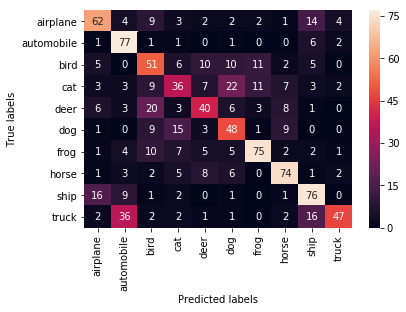

In [56]:
ax= plt.subplot()
sn.heatmap(test_cm, annot=True, ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

In [57]:
# Probability of correct recognition on test set
np.mean(test_labels == cnn_preds) 

0.586

In [58]:
# Probability of error on test set
np.mean(test_labels != cnn_preds)

0.414